In [1]:
# Input:
path_data = '../../01 data/train_pollution.csv'
n_lag = 3

path_01 = '../../03 outputs/parallel/01/'
path_scaler = path_01 + 'time_scaler.pickle'
path_x_train = path_01 + 'X_train.npy'
path_y_train = path_01 + 'y_train.npy'
path_x_val = path_01 + 'X_val.npy'
path_y_val = path_01 + 'y_val.npy'
path_x_test = path_01 + 'X_test.npy'
path_y_test = path_01 + 'y_test.npy'

path_02 = '../../03 outputs/parallel/02/'
path_forecaster_parallel = path_02 + 'forecaster_parallel.hdf5'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_error
import pickle
from keras.models import load_model

In [3]:
# Convert to datetime
def date_parser(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

# Load data
data = pd.read_csv(path_data)
data['date_time'] = data['date_time'].apply(date_parser)
data = data[
    ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
]
data = data.loc[n_lag:, :]
print(data.shape)
data.head(3)

(7108, 3)


,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
3,2.2,9.7,177.2
4,1.5,6.4,121.8
5,1.2,4.4,88.1


In [4]:
# Load data (lag 3 steps)
X_train = np.load(open(path_x_train, 'rb'))
y_train = np.load(open(path_y_train, 'rb'))
X_val = np.load(open(path_x_val, 'rb'))
y_val = np.load(open(path_y_val, 'rb'))
X_test = np.load(open(path_x_test, 'rb'))
y_test = np.load(open(path_y_test, 'rb'))

In [5]:
# Load model and tokenizer
scaler = pickle.load(open(path_scaler, 'rb'))

forecaster_lstm = load_model(path_forecaster_parallel)

In [8]:
# Forecast train
pred_train = forecaster_lstm.predict(X_train, verbose=0)
pred_train = scaler.inverse_transform(pred_train)
pred_train = pd.DataFrame(pred_train, columns=['prediction_carbon_monoxide', 'prediction_benzene', 'prediction_nitrogen_oxides'])

# Forecast val
pred_val = forecaster_lstm.predict(X_val, verbose=0)
pred_val = scaler.inverse_transform(pred_val)
pred_val = pd.DataFrame(pred_val, columns=['prediction_carbon_monoxide', 'prediction_benzene', 'prediction_nitrogen_oxides'])

# Forecast test
pred_test = forecaster_lstm.predict(X_test, verbose=0)
pred_test = scaler.inverse_transform(pred_test)
pred_test = pd.DataFrame(pred_test, columns=['prediction_carbon_monoxide', 'prediction_benzene', 'prediction_nitrogen_oxides'])

In [9]:
# Combine predictions
pred_train['split'] = 'train'
pred_val['split'] = 'val'
pred_test['split'] = 'test'

pred = pd.concat([pred_train, pred_val, pred_test], axis=0).reset_index(drop=True)
pred.index = pred.index + n_lag

# Combine with original data
pred = pd.concat([data, pred], axis=1)
print(pred.shape)
pred.head(3)

(7108, 7)


,target_carbon_monoxide,target_benzene,target_nitrogen_oxides,prediction_carbon_monoxide,prediction_benzene,prediction_nitrogen_oxides,split
3,2.2,9.7,177.2,1.945641,9.873182,114.222191,train
4,1.5,6.4,121.8,2.103067,10.478303,130.240662,train
5,1.2,4.4,88.1,1.553064,7.353176,110.662056,train


In [10]:
# Check the split boundary
train_split = pred[pred['split']=='train'].index[-1]
val_split = pred[pred['split']=='val'].index[-1]
print(train_split, val_split)

4622 5689


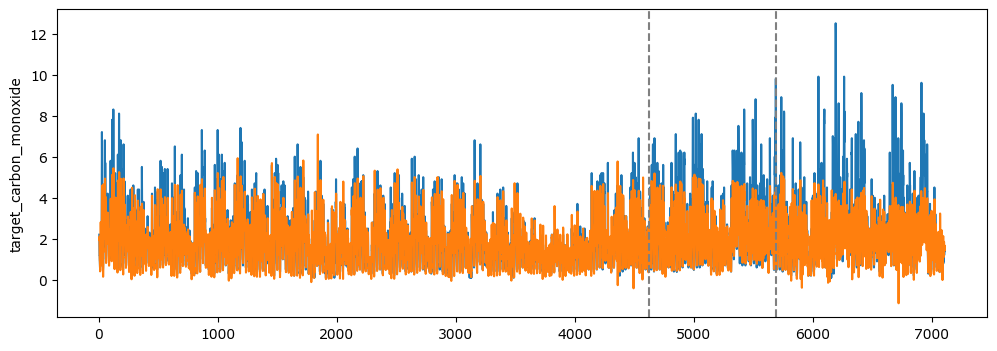

In [12]:
# Plot
plt.figure(figsize=(12,4))
sns.lineplot(pred, x=pred.index, y='target_carbon_monoxide')
sns.lineplot(pred, x=pred.index, y='prediction_carbon_monoxide')
plt.axvline(train_split, linestyle='--', color='grey')
plt.axvline(val_split, linestyle='--', color='grey')
plt.show()

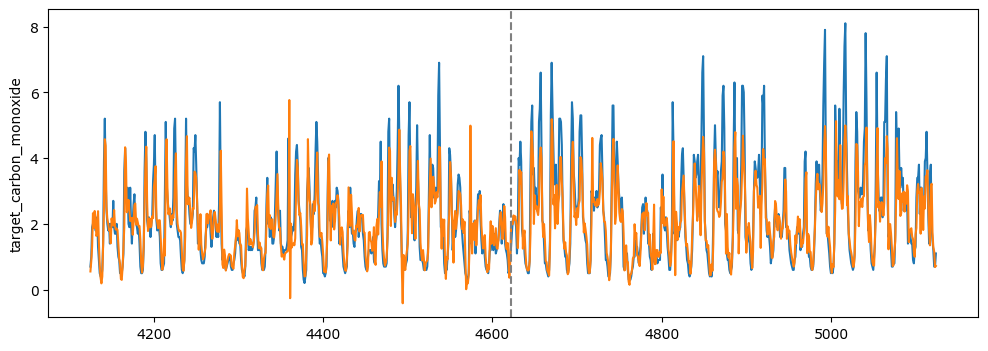

In [13]:
# Plot partial
plt.figure(figsize=(12,4))
sns.lineplot(pred.iloc[train_split-500:train_split+500,:], x=pred.iloc[train_split-500:train_split+500,:].index, y='target_carbon_monoxide')
sns.lineplot(pred.iloc[train_split-500:train_split+500,:], x=pred.iloc[train_split-500:train_split+500,:].index, y='prediction_carbon_monoxide')
plt.axvline(train_split, linestyle='--', color='grey')
plt.show()

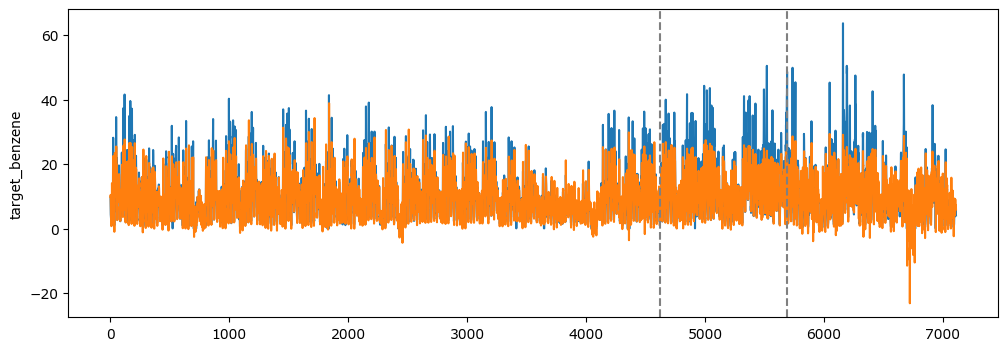

In [17]:
# Plot
plt.figure(figsize=(12,4))
sns.lineplot(pred, x=pred.index, y='target_benzene')
sns.lineplot(pred, x=pred.index, y='prediction_benzene')
plt.axvline(train_split, linestyle='--', color='grey')
plt.axvline(val_split, linestyle='--', color='grey')
plt.show()

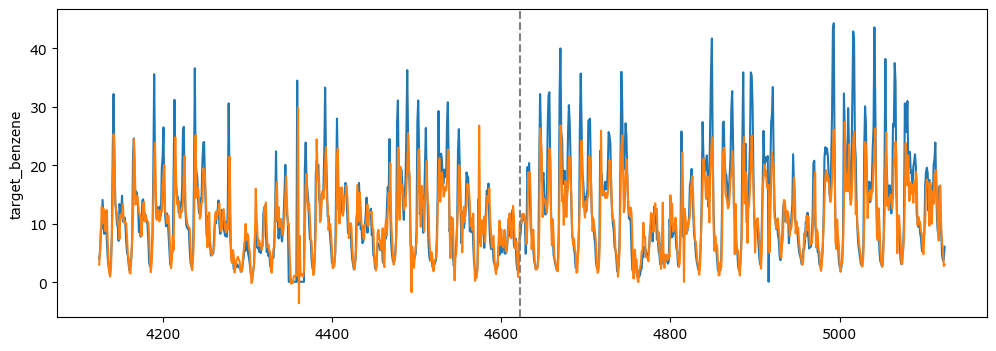

In [16]:
# Plot partial
plt.figure(figsize=(12,4))
sns.lineplot(pred.iloc[train_split-500:train_split+500,:], x=pred.iloc[train_split-500:train_split+500,:].index, y='target_benzene')
sns.lineplot(pred.iloc[train_split-500:train_split+500,:], x=pred.iloc[train_split-500:train_split+500,:].index, y='prediction_benzene')
plt.axvline(train_split, linestyle='--', color='grey')
plt.show()

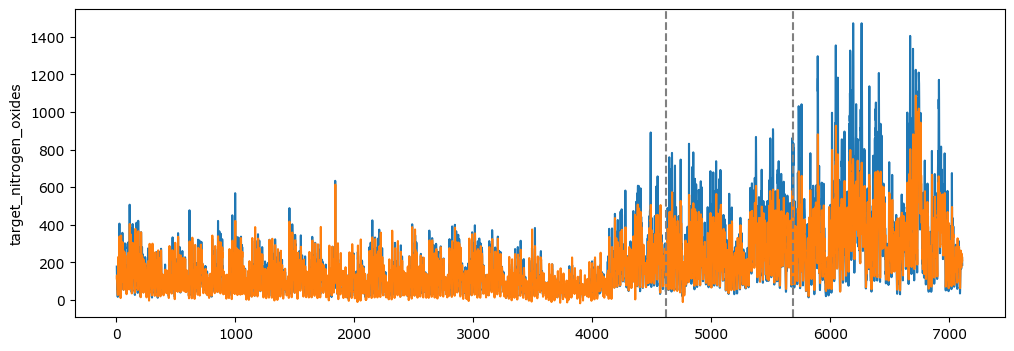

In [20]:
# Plot
plt.figure(figsize=(12,4))
sns.lineplot(pred, x=pred.index, y='target_nitrogen_oxides')
sns.lineplot(pred, x=pred.index, y='prediction_nitrogen_oxides')
plt.axvline(train_split, linestyle='--', color='grey')
plt.axvline(val_split, linestyle='--', color='grey')
plt.show()

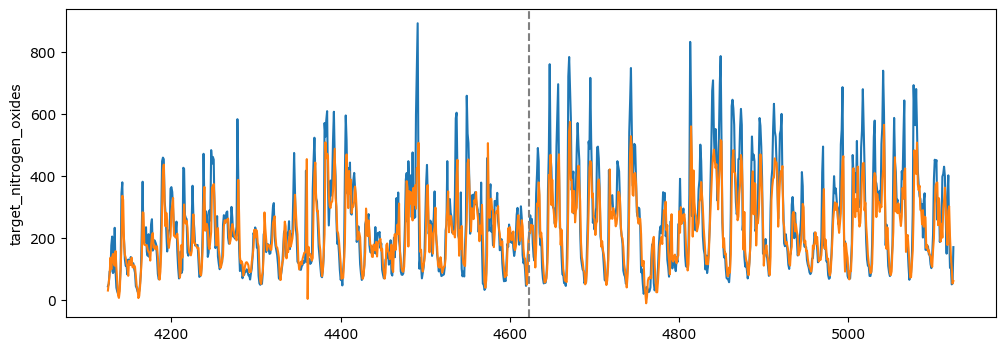

In [21]:
# Plot partial
plt.figure(figsize=(12,4))
sns.lineplot(pred.iloc[train_split-500:train_split+500,:], x=pred.iloc[train_split-500:train_split+500,:].index, y='target_nitrogen_oxides')
sns.lineplot(pred.iloc[train_split-500:train_split+500,:], x=pred.iloc[train_split-500:train_split+500,:].index, y='prediction_nitrogen_oxides')
plt.axvline(train_split, linestyle='--', color='grey')
plt.show()

In [28]:
# Accuracy
def compute_error(var):
    print('')
    print(var)
    mae_train = round(mean_absolute_error(pred.loc[pred['split']=='train', f'target_{var}'], pred.loc[pred['split']=='train', f'prediction_{var}']), 4)
    mae_val = round(mean_absolute_error(pred.loc[pred['split']=='val', f'target_{var}'], pred.loc[pred['split']=='val', f'prediction_{var}']), 4)
    mae_test = round(mean_absolute_error(pred.loc[pred['split']=='test', f'target_{var}'], pred.loc[pred['split']=='test', f'prediction_{var}']), 4)
    print(f'training MAE: {mae_train}')
    print(f'validation MAE: {mae_val}')
    print(f'testing MAE: {mae_test}')
    print(f'std: ' + str(round(pred[pred['split']=='train'][f'target_{var}'].std(),3)))

In [29]:
# Check the std of the train data
compute_error('carbon_monoxide')
compute_error('benzene')
compute_error('nitrogen_oxides')


carbon_monoxide
training MAE: 0.4391
validation MAE: 0.6337
testing MAE: 0.8737
std: 1.192

benzene
training MAE: 2.4232
validation MAE: 3.6381
testing MAE: 3.5806
std: 6.69

nitrogen_oxides
training MAE: 30.643
validation MAE: 73.8152
testing MAE: 110.0055
std: 89.556


In [30]:
# Save
pred.to_csv('../../03 outputs/parallel/03/prediction_parallel.csv')